# Training Analysis - Italic Detection Model

This notebook analyzes the training process and visualizes model performance metrics.

## Setup and Imports

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

# Add parent directory to path
# Struktur: italic-automation-system/notebooks/training_analysis.ipynb
#           italic-automation-system/src/config.py
current_dir = Path.cwd()  # notebooks/
project_root = current_dir.parent  # italic-automation-system/

# Add project root to Python path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Verify path
print(f"Current dir: {current_dir}")
print(f"Project root: {project_root}")
print(f"Python path: {sys.path[:2]}")

# Import config
import src.config as config

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

print("✅ Imports successful")
print(f"MODEL_DIR: {config.MODEL_DIR}")
print(f"LOG_DIR: {config.LOG_DIR}")

Current dir: d:\Documents\Kuliah\semester 7\italic-automation-system\notebooks
Project root: d:\Documents\Kuliah\semester 7\italic-automation-system
Python path: ['d:\\Documents\\Kuliah\\semester 7\\italic-automation-system', 'C:\\Program Files\\Python312\\python312.zip']
✅ Imports successful
MODEL_DIR: d:\Documents\Kuliah\semester 7\italic-automation-system\models
LOG_DIR: d:\Documents\Kuliah\semester 7\italic-automation-system\logs


## Load Training Metrics

In [3]:
# Load training metrics
metrics_path = config.MODEL_DIR / 'indobert-italic' / 'training_metrics.json'

if metrics_path.exists():
    with open(metrics_path, 'r') as f:
        training_metrics = json.load(f)
    print("✅ Training metrics loaded")
    print(f"Available metrics: {list(training_metrics.keys())}")
else:
    print("❌ Training metrics not found. Run training first.")
    print(f"Expected path: {metrics_path}")

✅ Training metrics loaded
Available metrics: ['eval_loss', 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch']


In [4]:
# Display final metrics
if 'training_metrics' in locals():
    print("Final Validation Metrics:")
    print("="*50)
    for key, value in training_metrics.items():
        if isinstance(value, float):
            print(f"{key:20s}: {value:.4f}")
        else:
            print(f"{key:20s}: {value}")

Final Validation Metrics:
eval_loss           : 0.0448
eval_accuracy       : 0.9902
eval_precision      : 0.9824
eval_recall         : 0.9890
eval_f1             : 0.9856
eval_runtime        : 6.2349
eval_samples_per_second: 25.5020
eval_steps_per_second: 1.6040
epoch               : 7.0000


## Load TensorBoard Logs

Note: This requires TensorBoard event files in the logs directory.

In [5]:
# Try to load TensorBoard logs
try:
    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
    
    log_dir = config.LOG_DIR
    
    # Find event files
    event_files = list(log_dir.rglob('events.out.tfevents.*'))
    
    if event_files:
        print(f"✅ Found {len(event_files)} TensorBoard event file(s)")
        
        # Load the most recent one
        latest_event = sorted(event_files)[-1]
        print(f"Loading: {latest_event}")
        
        event_acc = EventAccumulator(str(latest_event.parent))
        event_acc.Reload()
        
        print(f"Available tags: {event_acc.Tags()}")
    else:
        print("⚠️  No TensorBoard event files found")
        event_acc = None
        
except ImportError:
    print("⚠️  TensorBoard not installed. Install with: pip install tensorboard")
    event_acc = None
except Exception as e:
    print(f"⚠️  Error loading TensorBoard logs: {e}")
    event_acc = None

✅ Found 10 TensorBoard event file(s)
Loading: d:\Documents\Kuliah\semester 7\italic-automation-system\logs\events.out.tfevents.1768719756.FADHILARAHMADANI.24664.1
Available tags: {'images': [], 'audio': [], 'histograms': [], 'scalars': ['train/loss', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/accuracy', 'eval/precision', 'eval/recall', 'eval/f1', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss'], 'distributions': [], 'tensors': ['args/text_summary', 'model_config/text_summary'], 'graph': False, 'meta_graph': False, 'run_metadata': []}


## Visualize Training Curves

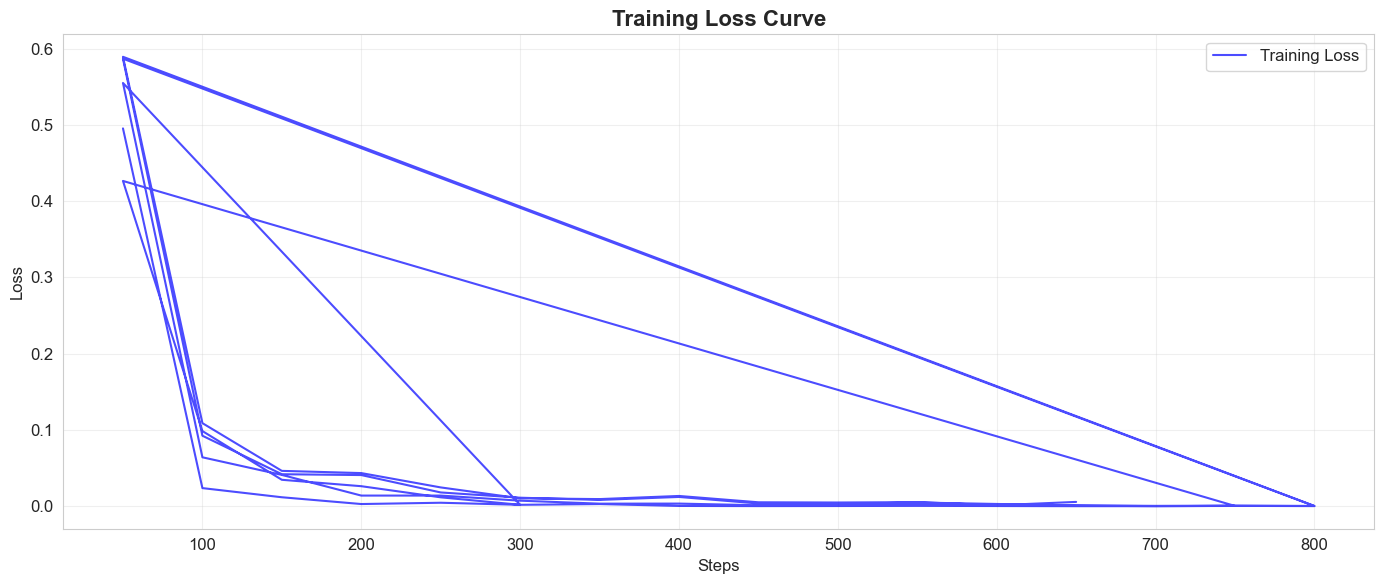

In [6]:
if event_acc is not None:
    # Extract training loss
    try:
        train_loss = event_acc.Scalars('train/loss')
        steps_train = [x.step for x in train_loss]
        values_train = [x.value for x in train_loss]
        
        # Plot training loss
        plt.figure(figsize=(14, 6))
        plt.plot(steps_train, values_train, label='Training Loss', color='blue', alpha=0.7)
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve', fontsize=16, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except:
        print("⚠️  Training loss curve not available")
else:
    print("⚠️  Cannot plot training curves without TensorBoard logs")

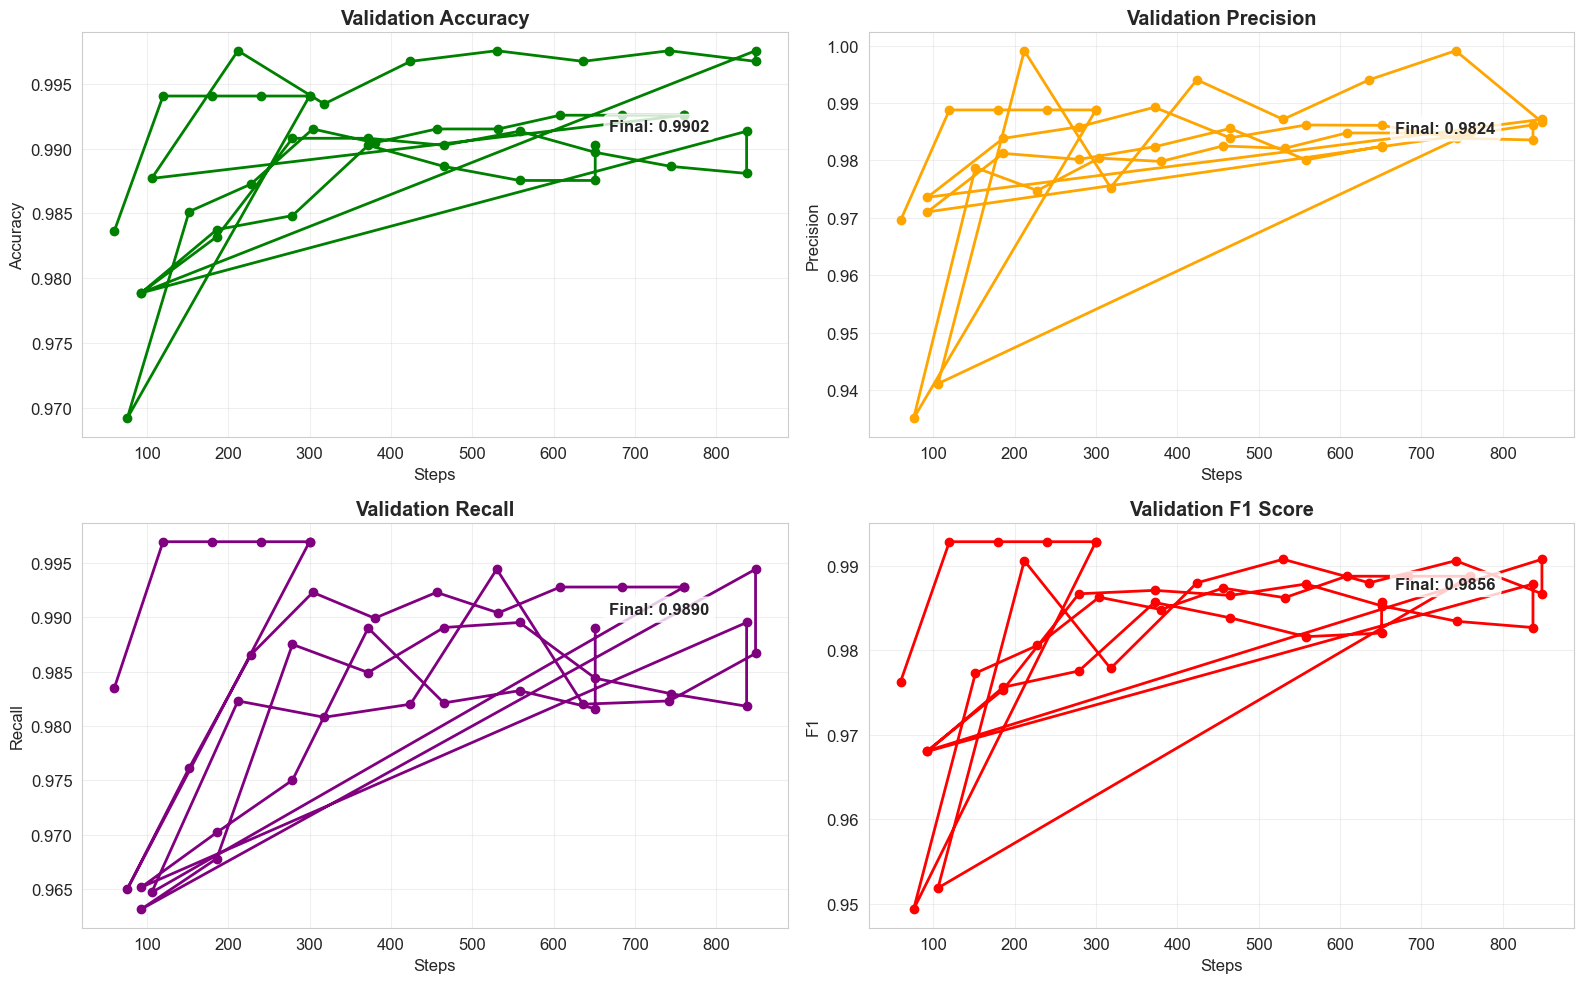

In [7]:
if event_acc is not None:
    # Extract validation metrics
    try:
        eval_metrics = {}
        for metric in ['eval/loss', 'eval/accuracy', 'eval/precision', 'eval/recall', 'eval/f1']:
            try:
                data = event_acc.Scalars(metric)
                eval_metrics[metric] = {
                    'steps': [x.step for x in data],
                    'values': [x.value for x in data]
                }
            except:
                pass
        
        if eval_metrics:
            # Plot all metrics
            fig, axes = plt.subplots(2, 2, figsize=(16, 10))
            axes = axes.flatten()
            
            metric_names = ['eval/accuracy', 'eval/precision', 'eval/recall', 'eval/f1']
            titles = ['Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1 Score']
            colors = ['green', 'orange', 'purple', 'red']
            
            for i, (metric, title, color) in enumerate(zip(metric_names, titles, colors)):
                if metric in eval_metrics:
                    axes[i].plot(eval_metrics[metric]['steps'], 
                               eval_metrics[metric]['values'], 
                               color=color, linewidth=2, marker='o')
                    axes[i].set_xlabel('Steps')
                    axes[i].set_ylabel(title.split()[1])
                    axes[i].set_title(title, fontweight='bold')
                    axes[i].grid(True, alpha=0.3)
                    
                    # Add final value annotation
                    final_val = eval_metrics[metric]['values'][-1]
                    axes[i].annotate(f'Final: {final_val:.4f}',
                                   xy=(eval_metrics[metric]['steps'][-1], final_val),
                                   xytext=(10, 10), textcoords='offset points',
                                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                                   fontweight='bold')
            
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️  No evaluation metrics found in TensorBoard logs")
    except Exception as e:
        print(f"⚠️  Error plotting validation metrics: {e}")
else:
    print("⚠️  Cannot plot validation curves without TensorBoard logs")

## Load Test Results

In [8]:
# Load test results
test_results_path = config.MODEL_DIR / 'indobert-italic' / 'test_results.json'

if test_results_path.exists():
    with open(test_results_path, 'r') as f:
        test_results = json.load(f)
    print("✅ Test results loaded")
    
    # Display classification report
    if 'classification_report' in test_results:
        print("\nTest Set Classification Report:")
        print("="*80)
        print(test_results['classification_report'])
else:
    print("❌ Test results not found. Run evaluation first.")
    test_results = None

✅ Test results loaded

Test Set Classification Report:
              precision    recall  f1-score   support

           O     0.9952    0.9952    0.9952      1261
           B     0.9740    0.9597    0.9668       273
           I     0.9772    0.9901    0.9836       303

    accuracy                         0.9891      1837
   macro avg     0.9821    0.9817    0.9819      1837
weighted avg     0.9891    0.9891    0.9891      1837



## Visualize Confusion Matrix

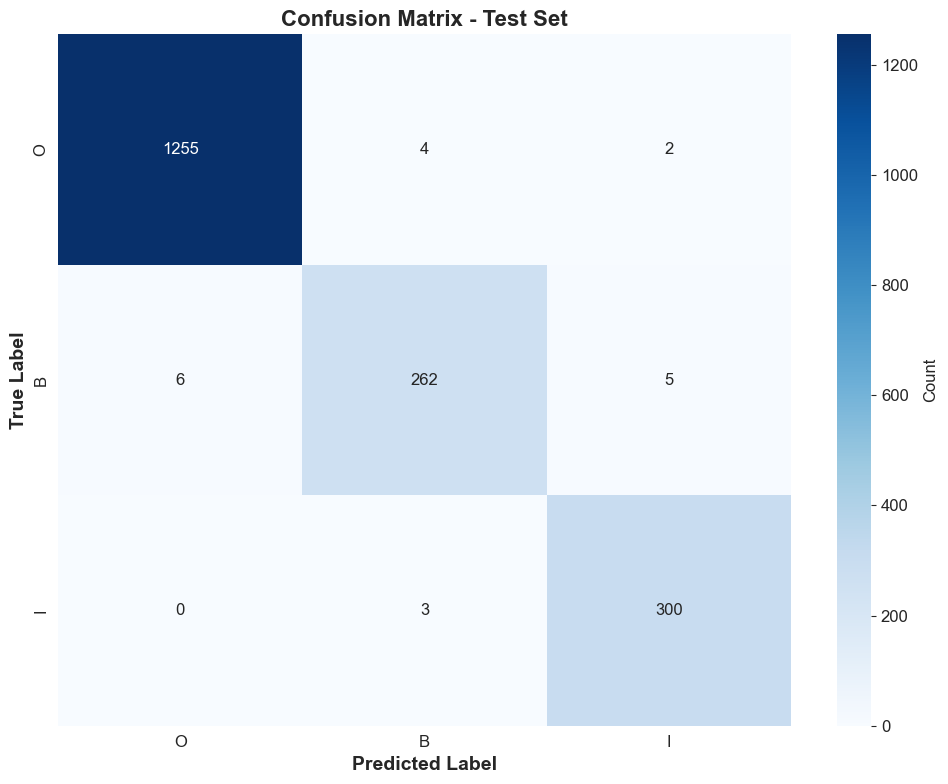


Per-Class Accuracy:
O    : 0.9952 (99.52%)
B    : 0.9597 (95.97%)
I    : 0.9901 (99.01%)


In [9]:
if test_results is not None and 'confusion_matrix' in test_results:
    cm = np.array(test_results['confusion_matrix'])
    labels = ['O', 'B', 'I']
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Calculate and display per-class accuracy
    print("\nPer-Class Accuracy:")
    print("="*50)
    for i, label in enumerate(labels):
        accuracy = cm[i, i] / cm[i].sum()
        print(f"{label:5s}: {accuracy:.4f} ({accuracy*100:.2f}%)")
else:
    print("⚠️  Confusion matrix not available")

## Model Performance Summary


Model Performance Summary:
   Metric  Validation
 Accuracy    0.990249
Precision    0.982379
   Recall    0.989012
 F1 Score    0.985647


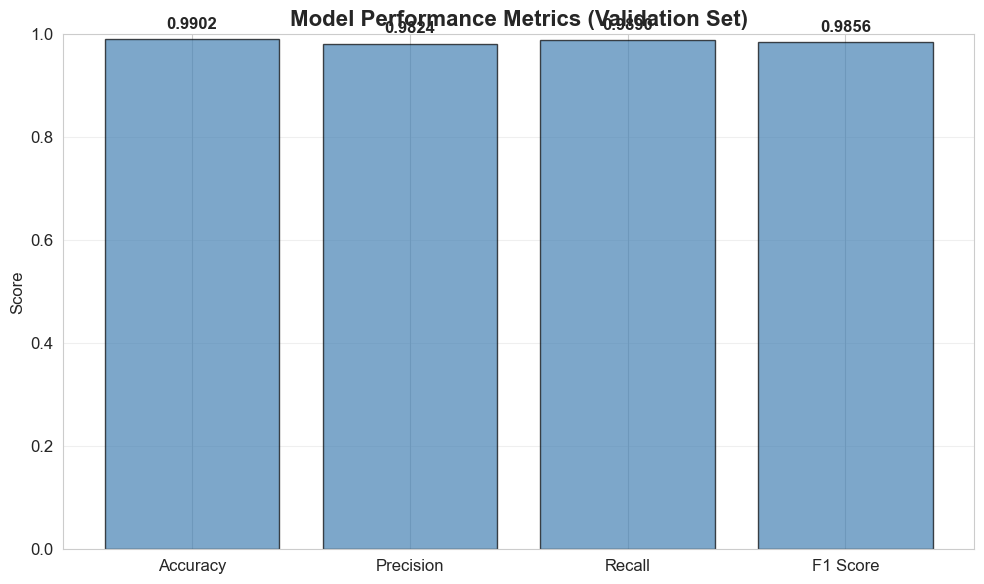

In [10]:
# Create summary dataframe
if 'training_metrics' in locals():
    summary_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Validation': [
            training_metrics.get('eval_accuracy', 0),
            training_metrics.get('eval_precision', 0),
            training_metrics.get('eval_recall', 0),
            training_metrics.get('eval_f1', 0)
        ]
    }
    
    df_summary = pd.DataFrame(summary_data)
    
    print("\nModel Performance Summary:")
    print("="*50)
    print(df_summary.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    x = range(len(df_summary))
    plt.bar(x, df_summary['Validation'], color='steelblue', alpha=0.7, edgecolor='black')
    plt.xticks(x, df_summary['Metric'])
    plt.ylabel('Score', fontsize=12)
    plt.title('Model Performance Metrics (Validation Set)', fontsize=16, fontweight='bold')
    plt.ylim(0, 1.0)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(df_summary['Validation']):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## Save Visualizations

In [11]:
# Create output directory for plots
output_dir = config.MODEL_DIR / 'training_visualizations'
output_dir.mkdir(exist_ok=True)

print(f"Visualizations can be saved to: {output_dir}")
print("\nTo save plots, add plt.savefig() before plt.show() in cells above.")

Visualizations can be saved to: d:\Documents\Kuliah\semester 7\italic-automation-system\models\training_visualizations

To save plots, add plt.savefig() before plt.show() in cells above.


## Recommendations

Based on the training analysis:

1. **Model Convergence**: Periksa apakah loss pelatihan sudah mencapai plateau (stabil)
2. **Overfitting**: Bandingkan metrik pelatihan vs validasi
3. **Class Imbalance**: tinjau confusion matrix untuk masalah spesifik per kelas
4. **Early Stopping**: Verifikasi apakah early stopping terpicu dengan tepat
